# Intro to Deep Learning Class

### Dataset:
- Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)£

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

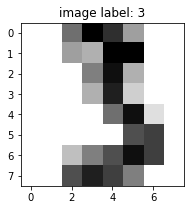

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# TO DO: 
# transform the digits.data and the digits.target into numppy arrays
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

# split the dataset with a test_size=0.15, random_state=37
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
# use the preprocessing.StandardScaler() function of sci-kit learn
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Numpy Implementation

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [5]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


In [6]:
EPSILON=1e-8 # to avoid having log 0 

def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    # TODO
    # implement the negative log likelihood here. 
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

In [7]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

### Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

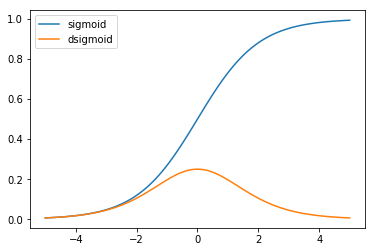

In [8]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    sig=sigmoid(X)
    return sig * (1 - sig)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

In [9]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o =np.zeros(output_size)
        self.output_size = output_size
        
    def forward(self, X):
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y
    
    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h
    
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, X, y_true):
        y, h, z_h = self.forward_keep_activations(X)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [10]:
n_hidden = 10
n_features = X_train.shape[1]
n_classes=10
model = NeuralNet(n_features, n_hidden, n_classes)

In [11]:
model.loss(X_train, y_train)

2.3028488694859552

In [12]:
model.accuracy(X_train, y_train)

0.10150622134905042

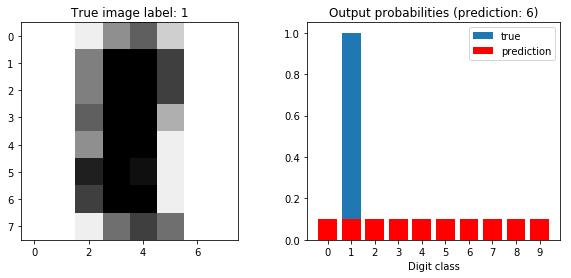

In [13]:
plot_prediction(model, sample_idx=5)

In [14]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30285, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 0.39438, train acc: 0.897, test acc: 0.852
Epoch #2, train loss: 0.17588, train acc: 0.958, test acc: 0.922
Epoch #3, train loss: 0.12032, train acc: 0.973, test acc: 0.937
Epoch #4, train loss: 0.08999, train acc: 0.984, test acc: 0.952
Epoch #5, train loss: 0.06666, train acc: 0.988, test acc: 0.948
Epoch #6, train loss: 0.04916, train acc: 0.992, test acc: 0.959
Epoch #7, train loss: 0.04209, train acc: 0.994, test acc: 0.959
Epoch #8, train loss: 0.03545, train acc: 0.997, test acc: 0.963
Epoch #9, train loss: 0.03029, train acc: 0.998, test acc: 0.963
Epoch #10, train loss: 0.02653, train acc: 0.999, test acc: 0.963
Epoch #11, train loss: 0.02261, train acc: 1.000, test acc: 0.967
Epoch #12, train loss: 0.02013, train acc: 1.000, test acc: 0.963
Epoch #13, train loss: 0.01812, train acc: 1.000, test acc: 0.963
Epoch #14, train loss: 0.01645, train acc: 1.000, test acc: 0.963
Epoch #15, train 

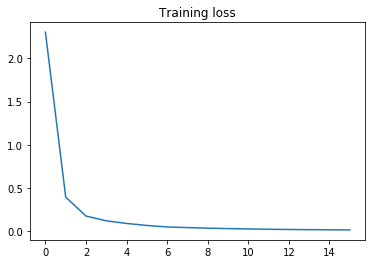

In [15]:
plt.plot(losses)
plt.title("Training loss");

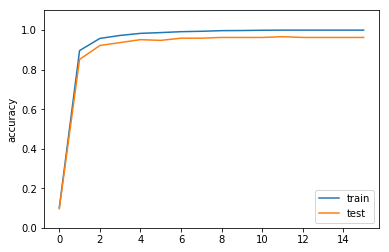

In [16]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

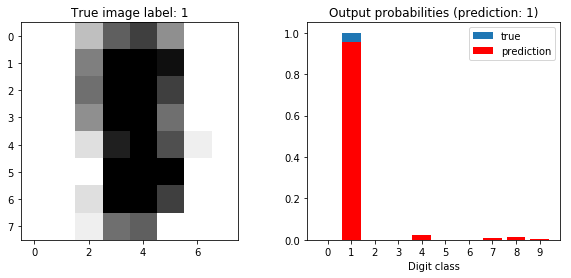

In [17]:
plot_prediction(model, sample_idx=4)

## Exercice 1.

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- **Bonus: Implement momentum**


### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

# Réponses :


### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.

In [26]:
learning_rates = [0.01, 0.1, 0.5 , 1]
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []

for lr in learning_rates:
    for epoch in range(15):
        for i, (x, y) in enumerate(zip(X_train, y_train)):
            model.train(x, y, lr)

        losses.append(model.loss(X_train, y_train))
        accuracies.append(model.accuracy(X_train, y_train))
        accuracies_test.append(model.accuracy(X_test, y_test))
        print("Learning rate : #%0.2f,Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (lr,epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Learning rate : #0.01,Epoch #1, train loss: 2.29339, train acc: 0.166, test acc: 0.133
Learning rate : #0.01,Epoch #2, train loss: 1.91656, train acc: 0.379, test acc: 0.330
Learning rate : #0.01,Epoch #3, train loss: 1.39233, train acc: 0.663, test acc: 0.622
Learning rate : #0.01,Epoch #4, train loss: 1.03014, train acc: 0.776, test acc: 0.737
Learning rate : #0.01,Epoch #5, train loss: 0.77926, train acc: 0.828, test acc: 0.804
Learning rate : #0.01,Epoch #6, train loss: 0.61307, train acc: 0.863, test acc: 0.822
Learning rate : #0.01,Epoch #7, train loss: 0.49821, train acc: 0.893, test acc: 0.870
Learning rate : #0.01,Epoch #8, train loss: 0.41574, train acc: 0.919, test acc: 0.893
Learning rate : #0.01,Epoch #9, train loss: 0.35437, train acc: 0.936, test acc: 0.930
Learning rate : #0.01,Epoch #10, train loss: 0.30711, train acc: 0.952, test acc: 0.948
Learning rate : #0.01,Epoch #11, train loss: 0.26989, train acc: 0.962, test acc: 0.948
Learning rate : #0.01,Epoch #12, train lo

In [25]:
hidden_layer_sizes = [5, 10, 15, 20]

losses, accuracies, accuracies_test = [], [], []

for size in hidden_layer_sizes:
    model = NeuralNet(n_features, size, n_classes)
    for epoch in range(15):
        for i, (x, y) in enumerate(zip(X_train, y_train)):
            model.train(x, y, 0.1)
        losses.append(model.loss(X_train, y_train))
        accuracies.append(model.accuracy(X_train, y_train))
        accuracies_test.append(model.accuracy(X_test, y_test))
        print("size of hidden layer : #%d,Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (size,epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

size of hidden layer : #5,Epoch #1, train loss: 0.67671, train acc: 0.845, test acc: 0.815
size of hidden layer : #5,Epoch #2, train loss: 0.33441, train acc: 0.923, test acc: 0.881
size of hidden layer : #5,Epoch #3, train loss: 0.26108, train acc: 0.936, test acc: 0.893
size of hidden layer : #5,Epoch #4, train loss: 0.25479, train acc: 0.929, test acc: 0.863
size of hidden layer : #5,Epoch #5, train loss: 0.20808, train acc: 0.948, test acc: 0.889
size of hidden layer : #5,Epoch #6, train loss: 0.17981, train acc: 0.955, test acc: 0.915
size of hidden layer : #5,Epoch #7, train loss: 0.16308, train acc: 0.961, test acc: 0.907
size of hidden layer : #5,Epoch #8, train loss: 0.15485, train acc: 0.963, test acc: 0.915
size of hidden layer : #5,Epoch #9, train loss: 0.15806, train acc: 0.959, test acc: 0.900
size of hidden layer : #5,Epoch #10, train loss: 0.15267, train acc: 0.955, test acc: 0.907
size of hidden layer : #5,Epoch #11, train loss: 0.17368, train acc: 0.954, test acc: 0.9

In [98]:
#Def du second layer

class NeuralNet2HL():

    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        self.W_h1 = np.random.uniform(
            size=(input_size, hidden_size1), high=0.01, low=-0.01)
        self.W_h2 = np.random.uniform(
            size=(input_size, hidden_size2), high=0.01, low=-0.01)
        self.b_h1 = np.zeros(hidden_size1)
        self.b_h2 = np.zeros(hidden_size2)
        self.W_o = np.random.uniform(
            size=(hidden_size2, output_size), high=0.01, low=-0.01)
        self.b_o =np.zeros(output_size)
        self.output_size = output_size
        
    def forward(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = sigmoid(np.dot(X, self.W_h1) + self.b_h1)
        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = sigmoid(np.dot(X, self.W_h2) + self.b_h2)
        y = softmax(np.dot(h2, self.W_o) + self.b_o)
        return y
    
    def forward_keep_activations(self, X):
        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1 = sigmoid(z_h1)
        z_h2 = np.dot(X, self.W_h2) + self.b_h2
        h2 = sigmoid(z_h2)
        z_o = np.dot(h2, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h1, z_h1, h2 , z_h2
    
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, X, y_true):
        y, h1, z_h1, h2, z_h2 = self.forward_keep_activations(X)
        
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h2, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h2 = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h2 = grad_h2 * dsigmoid(z_h2)
        grad_W_h2 = np.outer(h1, grad_z_h2)
        grad_b_h2 = grad_z_h2
        
        grad_h1 = np.dot(grad_z_h2, np.transpose(self.W_h2))
        grad_z_h1 = grad_h1 * dsigmoid(z_h1)
        grad_W_h1 = np.outer(X, grad_z_h1)
        grad_b_h1 = grad_z_h1
        
        grads = {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_h2": grad_W_h2, "b_h2": grad_b_h2,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h1 = self.W_h1 - learning_rate * grads["W_h1"]
        self.b_h1 = self.b_h1 - learning_rate * grads["b_h1"]
        self.W_h2 = self.W_h2 - learning_rate * grads["W_h2"]
        self.b_h2 = self.b_h2 - learning_rate * grads["b_h2"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [99]:
n_hidden1 = 10
n_hidden2 = 6
model = NeuralNet2HL(n_features, n_hidden1, n_hidden2, n_classes)

In [100]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(30):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

ValueError: shapes (1527,10) and (64,6) not aligned: 10 (dim 1) != 64 (dim 0)

### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

In [75]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers

N = X_train.shape[1]
H = 100
K = 10

model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("tanh"))
model.add(Dense(K))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, nb_epoch=15, batch_size=32)

Using TensorFlow backend.
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/15
1527/1527 [==============================] - 0s 65us/step - loss: 0.7823 - accuracy: 0.8022
Epoch 2/15
1527/1527 [==============================] - 0s 33us/step - loss: 0.2751 - accuracy: 0.9391
Epoch 3/15
1527/1527 [==============================] - 0s 31us/step - loss: 0.1887 - accuracy: 0.9614
Epoch 4/15
1527/1527 [==============================] - 0s 32us/step - loss: 0.1466 - accuracy: 0.9718
Epoch 5/15
1527/1527 [==============================] - 0s 32us/step - loss: 0.1220 - accuracy: 0.9784
Epoch 6/15
1527/1527 [==============================] - 0s 30us/step - loss: 0.1042 - accuracy: 0.9830
Epoch 7/15
1527/1527 [==============================] - 0s 31us/step - loss: 0.0919 - accuracy: 0.9836
Epoch 8/15
1527/1527 [==============================] - 0s 31us/step - loss: 0.0816 - accuracy: 0.9876
Epoch 9/15
1527/1527 [==============================] - 0s 23us/step - loss: 0.0732 - accuracy: 0.9876
Epoch 10/15
1527/1527 [==============================] - 0s 26us/step - l

Train on 1221 samples, validate on 306 samples
Epoch 1/6
1221/1221 [==============================] - 0s 129us/step - loss: 1.4696 - accuracy: 0.6077 - val_loss: 0.7508 - val_accuracy: 0.8660
Epoch 2/6
1221/1221 [==============================] - 0s 47us/step - loss: 0.5749 - accuracy: 0.8788 - val_loss: 0.3644 - val_accuracy: 0.9281
Epoch 3/6
1221/1221 [==============================] - 0s 44us/step - loss: 0.2907 - accuracy: 0.9550 - val_loss: 0.2401 - val_accuracy: 0.9575
Epoch 4/6
1221/1221 [==============================] - 0s 48us/step - loss: 0.1742 - accuracy: 0.9697 - val_loss: 0.1725 - val_accuracy: 0.9739
Epoch 5/6
1221/1221 [==============================] - 0s 55us/step - loss: 0.1214 - accuracy: 0.9820 - val_loss: 0.1401 - val_accuracy: 0.9771
Epoch 6/6
1221/1221 [==============================] - 0s 52us/step - loss: 0.0893 - accuracy: 0.9885 - val_loss: 0.1239 - val_accuracy: 0.9771
Train on 1221 samples, validate on 306 samples
Epoch 1/8
1221/1221 [====================

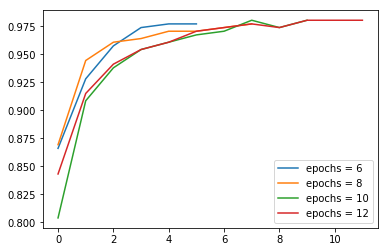

In [76]:
for i in [6,8,10,12]:
    model = Sequential()
    model.add(Dense(H, input_dim=N))
    model.add(Activation("tanh"))
    model.add(Dense(N, activation='relu'))
    model.add(Dense(K))
    model.add(Activation("softmax"))

    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, Y_train, epochs=i, batch_size=32,validation_split=0.2)

    lines=plt.plot(range(0,i,1),model.history.history["val_accuracy"])
    
    plt.legend( ['epochs = 6', 'epochs = 8','epochs = 10', 'epochs = 12']);

In [77]:
# id idx
idx = 42
# Conditional proba for test sample 
y_pred_proba = model.predict_proba(X_test, verbose=0)
print('Conditional probabilities of sample nb %d'%idx)
np.around(y_pred_proba[42], 5)
print('Negative log-likelihood of sample nb %d'%idx)
y_pred_proba[idx, y_test[idx]] # relevant with above

Conditional probabilities of sample nb 42
Negative log-likelihood of sample nb 42


0.99807215

In [78]:
Y_test = to_categorical(y_test)
ll = np.sum(np.log(y_pred_proba) * Y_test, axis=1)
print('Negative log-likelihood on test set: %0.4f'%-np.mean(ll))

Negative log-likelihood on test set: 0.0752


## Exercice 2. Impact of initialization

Let us now study the impact of a bad initialization when training
a deep feed forward network.

By default Keras dense layers use the "Glorot Uniform" initialization
strategy to initialize the weight matrices:

- each weight coefficient is randomly sampled from [-scale, scale]
- scale is proportional to $\frac{1}{\sqrt{n_{in} + n_{out}}}$

This strategy is known to work well to initialize deep neural networks
with "tanh" or "relu" activation functions and then trained with
standard SGD.

To assess the impact of initialization let us plug an alternative init
scheme into a 2 hidden layers networks with "tanh" activations.
For the sake of the example let's use normal distributed weights
with a manually adjustable scale (standard deviation) and see the
impact the scale value:

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

In [45]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train)

In [67]:
N = X_train.shape[1]
H = 100
K = 10

normal_init = initializers.RandomNormal(stddev=0.01)

model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer=normal_init))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 255us/sample - loss: 2.3035
Epoch 2/10
1527/1527 [==============================] - 0s 40us/sample - loss: 2.3024
Epoch 3/10
1527/1527 [==============================] - 0s 41us/sample - loss: 2.3009
Epoch 4/10
1527/1527 [==============================] - 0s 40us/sample - loss: 2.2933
Epoch 5/10
1527/1527 [==============================] - 0s 45us/sample - loss: 2.1859
Epoch 6/10
1527/1527 [==============================] - 0s 47us/sample - loss: 1.8892
Epoch 7/10
1527/1527 [==============================] - 0s 44us/sample - loss: 1.5936
Epoch 8/10
1527/1527 [==============================] - 0s 37us/sample - loss: 1.3306
Epoch 9/10
1527/1527 [==============================] - 0s 33us/sample - loss: 1.0965
Epoch 10/10
1527/1527 [==============================] - 0s 43us/sample - loss: 0.8923


#### Questions:

- Try the following initialization schemes and see whether
  the SGD algorithm can successfully train the network or
  not:
  
  - a very small e.g. `scale=1e-3`
  - a larger scale e.g. `scale=1` or `10`
  - initialize all weights to 0 (constant initialization)
  
- What do you observe? Can you find an explanation for those
  outcomes?

- Are better solvers such as SGD with momentum or Adam able
  to deal better with such bad initializations?

## - very small e.g. scale=1e-3

In [68]:
##stddev = sqrt(scale / n)

stddev = np.sqrt(0.001 / N)

normal_init1 = initializers.RandomNormal(stddev=stddev)

model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer=normal_init1))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init1))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init1))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 202us/sample - loss: 2.3034
Epoch 2/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3030
Epoch 3/10
1527/1527 [==============================] - 0s 37us/sample - loss: 2.3031
Epoch 4/10
1527/1527 [==============================] - 0s 36us/sample - loss: 2.3029
Epoch 5/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3029
Epoch 6/10
1527/1527 [==============================] - 0s 36us/sample - loss: 2.3028
Epoch 7/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3030
Epoch 8/10
1527/1527 [==============================] - 0s 36us/sample - loss: 2.3028
Epoch 9/10
1527/1527 [==============================] - 0s 34us/sample - loss: 2.3028
Epoch 10/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3026


## - larger scale e.g. scale=1 or 10

In [69]:
##stddev = sqrt(scale / n)

stddev = np.sqrt(1 / N)

normal_init2 = initializers.RandomNormal(stddev=stddev)

model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer=normal_init2))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init2))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init2))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 155us/sample - loss: 1.8497
Epoch 2/10
1527/1527 [==============================] - 0s 41us/sample - loss: 1.0683
Epoch 3/10
1527/1527 [==============================] - 0s 41us/sample - loss: 0.6173
Epoch 4/10
1527/1527 [==============================] - 0s 39us/sample - loss: 0.4028
Epoch 5/10
1527/1527 [==============================] - 0s 40us/sample - loss: 0.2937
Epoch 6/10
1527/1527 [==============================] - 0s 41us/sample - loss: 0.2311
Epoch 7/10
1527/1527 [==============================] - 0s 38us/sample - loss: 0.1897
Epoch 8/10
1527/1527 [==============================] - 0s 38us/sample - loss: 0.1606
Epoch 9/10
1527/1527 [==============================] - 0s 38us/sample - loss: 0.1393
Epoch 10/10
1527/1527 [==============================] - 0s 41us/sample - loss: 0.1227


In [70]:
##stddev = sqrt(scale / n)

stddev = np.sqrt(10 / N)

normal_init3 = initializers.RandomNormal(stddev=stddev)

model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer=normal_init3))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init3))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init3))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 154us/sample - loss: 1.7672
Epoch 2/10
1527/1527 [==============================] - 0s 39us/sample - loss: 1.0195
Epoch 3/10
1527/1527 [==============================] - 0s 40us/sample - loss: 0.7443
Epoch 4/10
1527/1527 [==============================] - 0s 38us/sample - loss: 0.5692
Epoch 5/10
1527/1527 [==============================] - 0s 38us/sample - loss: 0.4521
Epoch 6/10
1527/1527 [==============================] - 0s 41us/sample - loss: 0.3684
Epoch 7/10
1527/1527 [==============================] - 0s 36us/sample - loss: 0.3096
Epoch 8/10
1527/1527 [==============================] - 0s 40us/sample - loss: 0.2655
Epoch 9/10
1527/1527 [==============================] - 0s 36us/sample - loss: 0.2295
Epoch 10/10
1527/1527 [==============================] - 0s 40us/sample - loss: 0.2008


## initialize all weights to 0 (constant initialization)

In [71]:
model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer='zeros'))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer='zeros'))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer='zeros'))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 155us/sample - loss: 2.3035
Epoch 2/10
1527/1527 [==============================] - 0s 40us/sample - loss: 2.3033
Epoch 3/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3032
Epoch 4/10
1527/1527 [==============================] - 0s 39us/sample - loss: 2.3032
Epoch 5/10
1527/1527 [==============================] - 0s 38us/sample - loss: 2.3030
Epoch 6/10
1527/1527 [==============================] - 0s 40us/sample - loss: 2.3028
Epoch 7/10
1527/1527 [==============================] - 0s 41us/sample - loss: 2.3030
Epoch 8/10
1527/1527 [==============================] - 0s 38us/sample - loss: 2.3030
Epoch 9/10
1527/1527 [==============================] - 0s 40us/sample - loss: 2.3030
Epoch 10/10
1527/1527 [==============================] - 0s 42us/sample - loss: 2.3032


- Dans le cas où on fait une grande ou petite initialisation, le loss diffère largement. Pour une petite init, ça reste difficile de réduire le loss. Pour une grande init, on a un loss qui est trop prêt du 0, le model est plus confiant.
- Initialisation à 0, c'est difficile de faire l'apprentissage du model car le loss ne change pas

Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 159us/sample - loss: 2.3035
Epoch 2/10
1527/1527 [==============================] - 0s 36us/sample - loss: 2.3030
Epoch 3/10
1527/1527 [==============================] - 0s 41us/sample - loss: 2.3031
Epoch 4/10
1527/1527 [==============================] - 0s 36us/sample - loss: 2.3029
Epoch 5/10
1527/1527 [==============================] - 0s 34us/sample - loss: 2.3030
Epoch 6/10
1527/1527 [==============================] - 0s 33us/sample - loss: 2.3029
Epoch 7/10
1527/1527 [==============================] - 0s 35us/sample - loss: 2.3029
Epoch 8/10
1527/1527 [==============================] - 0s 37us/sample - loss: 2.3030
Epoch 9/10
1527/1527 [==============================] - 0s 33us/sample - loss: 2.3027
Epoch 10/10
1527/1527 [==============================] - 0s 33us/sample - loss: 2.3028
Train on 1527 samples
Epoch 1/10
1527/1527 [==============================] - 0s 116us/sample - loss: 1.8480
Epoch 2

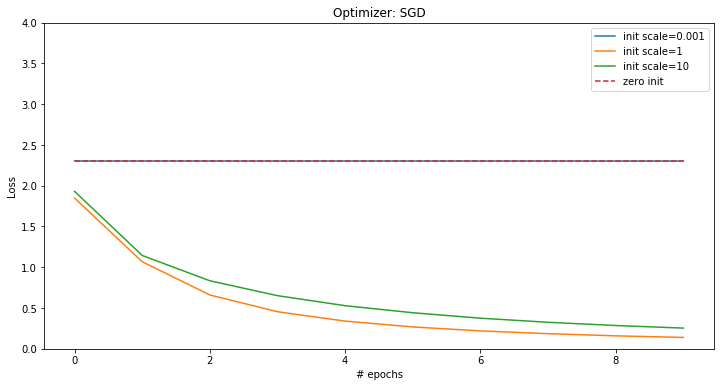

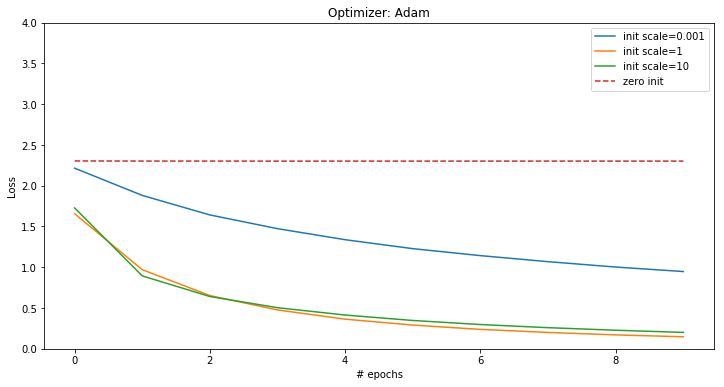

In [74]:

stddev3 = np.sqrt(10 / N)
normal_init3 = initializers.RandomNormal(stddev=stddev3)

stddev2 = np.sqrt(1 / N)
normal_init2 = initializers.RandomNormal(stddev=stddev2)

stddev1 = np.sqrt(0.001 / N)
normal_init1 = initializers.RandomNormal(stddev=stddev1)

optimizer_list = [
    ('SGD', optimizers.SGD(lr=0.1)),
    ('Adam', optimizers.Adam())
]

init_list = [
    ('init scale=0.001', normal_init1, '-'),
    ('init scale=1', normal_init2, '-'),
    ('init scale=10', normal_init3, '-'),
    ('zero init', 'zeros', '--'),
]

for optimizer_name, optimizer in optimizer_list:
    plt.figure(figsize=(12, 6))
    for init_name, init, linestyle in init_list:
        model = Sequential()
        model.add(Dense(H, input_dim=N, kernel_initializer=init))
        model.add(Activation("tanh"))
        model.add(Dense(K, kernel_initializer=init))
        model.add(Activation("tanh"))
        model.add(Dense(K, kernel_initializer=init))
        model.add(Activation("softmax"))
        
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy')

        history = model.fit(X_train, Y_train,
                            epochs=10, batch_size=32)
        plt.plot(history.history['loss'], linestyle=linestyle,
                 label=init_name)

    plt.xlabel('# epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 4)
    plt.legend(loc='best');
    plt.title('Optimizer: %s'
              % optimizer_name)

Adam a tendance à être plus robuste en cas de mauvaise initialisation grâce à ses ajustements du taux d’apprentissage par poids, mais bénéficie toujours d’une bonne initialisation.